# **Artificial Neural Networks and Deep Learning**

---

## **Challenge 1: Pirates Pain🏴‍☠️☠️**


# Notebook Summary

Using this notebook, I achieved my best submission on the Pirate Pain Challenge  
**Weighted F1 Score: 0.9554**  
with the following configuration:

- **N_VAL_USERS:** 80  
- **N_TEST_USERS:** 80 (I decided to create a local test set to avoid wasting submissions on Kaggle)
- **WINDOW_SIZE:** 40  
- **STRIDE:** 20  
- **LEARNING_RATE:** 1e-3  
- **HIDDEN_LAYERS:** 2  
- **HIDDEN_SIZE:** 128  
- **DROPOUT_RATE:** 0.2  
- **L1_LAMBDA:** 0  
- **L2_LAMBDA:** 0  
- **BATCH_SIZE:** 64  
- **Model:** BIDIRECTIONAL GRU

---

# Attempts to Improve Performance

After obtaining the best-performing baseline configuration, I explored several strategies to further improve the score:

## 1. Feature Reduction
Removed highly correlated joints (e.g., `joint_10`, `joint_11`), aiming to reduce redundancy and noise.  
**Outcome:** No improvement; the score was equal or slightly worse.

## 2. Window Importance Weighting
Computed the distance between class means at each timestep to identify the most discriminative temporal regions.  
Assigned higher weights to windows overlapping these intervals.  
**Outcome:** Improved validation behavior, but **no improvement on the final submission**.

## 3. Class Weight Softening (β-parameter)
Applied a softening factor β to class weights to avoid over-penalizing minority classes.  
**Outcome:** Training became smoother, but **submission score did not improve**.

In [167]:
# Define the number of users for validation and test sets
N_VAL_USERS = 80 # You can change this number
N_TEST_USERS = 80 # You can change this number

# Define the window size
WINDOW_SIZE = 32

# Define the stride for overlapping windows
STRIDE = 16

# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0          # L2 penalty

# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

#looking at the graph "Distance between class means at each timestep" we can change the importance of each window
IMPORTANT_SPANS = []  # important intervals
IMPORTANT_ALPHAS = []          # per-interval boost factors

beta = 1  # softening factor

## 🌐 **Google Drive Connection**

In [168]:

from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/[2025-2026]\\ AN2DL/Challenge\\ 1"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1


## ⚙️ **Libraries Import**

In [169]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [170]:
# Set environment variables for Activity Recognition dataset
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"

for f in [os.environ["TRAIN_FILE"], os.environ["LABEL_FILE"], os.environ["TEST_FILE"]]:
    assert os.path.exists(f), f"Missing file: {f}"
print("All dataset files found locally.")

All dataset files found locally.


## 🔎 **Exploration and Data Analysis**

In [171]:
# Load the training and labels datasets
X_train = pd.read_csv(os.environ["TRAIN_FILE"])
y_train = pd.read_csv(os.environ["LABEL_FILE"])

X_test_sub = pd.read_csv(os.environ["TEST_FILE"])

# Merge features and labels using 'sample_index'
df = X_train.merge(y_train, on="sample_index")
df_test_sub = X_test_sub
# Remove possible missing values
df.dropna(inplace=True)

# Print dataset shape and show sample
print(f"Training DataFrame shape: {df.shape}")
df.head(10)

Training DataFrame shape: (105760, 41)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5,no_pain
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5,no_pain
7,0,7,2,2,2,2,two,two,two,1.038597,...,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5,no_pain
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5,no_pain
9,0,9,0,2,2,2,two,two,two,1.054999,...,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5,no_pain


In [172]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [173]:
# Select all joint columns
joint_cols = [col for col in df.columns if col.startswith("joint_")]

# Converte in float32
df[joint_cols] = df[joint_cols].astype(np.float32)

# Double-check that everything is consistent
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [174]:
# Select all joint columns
joint_cols = [col for col in df_test_sub.columns if col.startswith("joint_")]

# Converte in float32
df_test_sub[joint_cols] = df_test_sub[joint_cols].astype(np.float32)

# Double-check that everything is consistent
df_test_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float32
 10  joint_01       211840 non-null  float32
 11  joint_02       211840 non-null  float32
 12  joint_03       211840 non-null  float32
 13  joint_04       211840 non-null  float32
 14  joint_05       211840 non-null  float32
 15  joint_06       211840 non-null  float32
 16  joint_07       211840 non-null  float32
 17  joint_08       211840 non-nul

In [175]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202049,0.197606,0.295603,0.300786,...,4.974359e-03,5.472111e-03,1.235068e-03,4.063172e-04,3.205551e-03,0.060292,0.079820,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746148e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079464e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


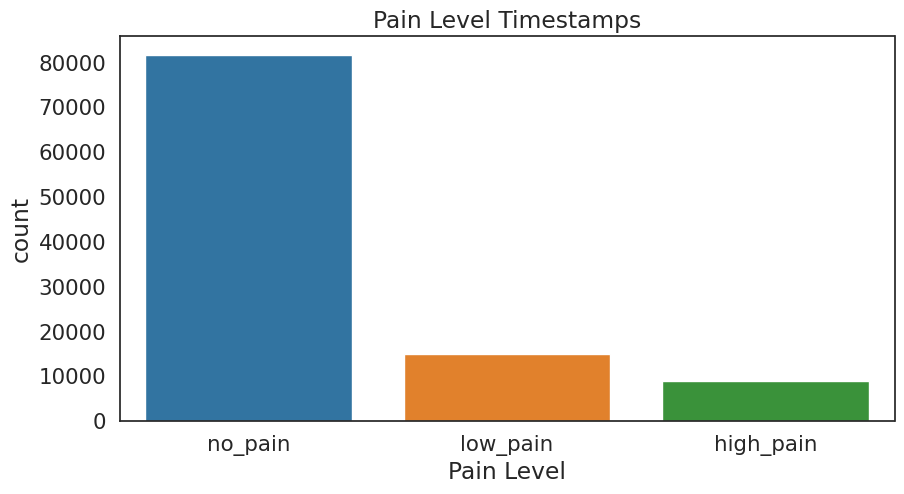

In [176]:
# Visualise the count of timestamps for each pain level
plt.figure(figsize=(10, 5))
sns.countplot(
    x='label',
    data=df,
    order=df['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pain Level Timestamps')
plt.xlabel('Pain Level')

# Display the plot
plt.show()

In [177]:
# Define a function to inspect data for a specific pain_level
def inspect_pain_level(pain_level, df, features=None, n_samples=160):
    # Select features (for example, 3 joints)
    if features is None:
        features = [c for c in df.columns if c.startswith("joint_")][:3]

    # Filtra le righe di quel livello di dolore
    data = df[df["label"] == pain_level][features].head(n_samples)

    # Plot
    ax = data.plot(subplots=True, figsize=(14, 8), title=f"Pain level: {pain_level}")

    for a in ax:
        a.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

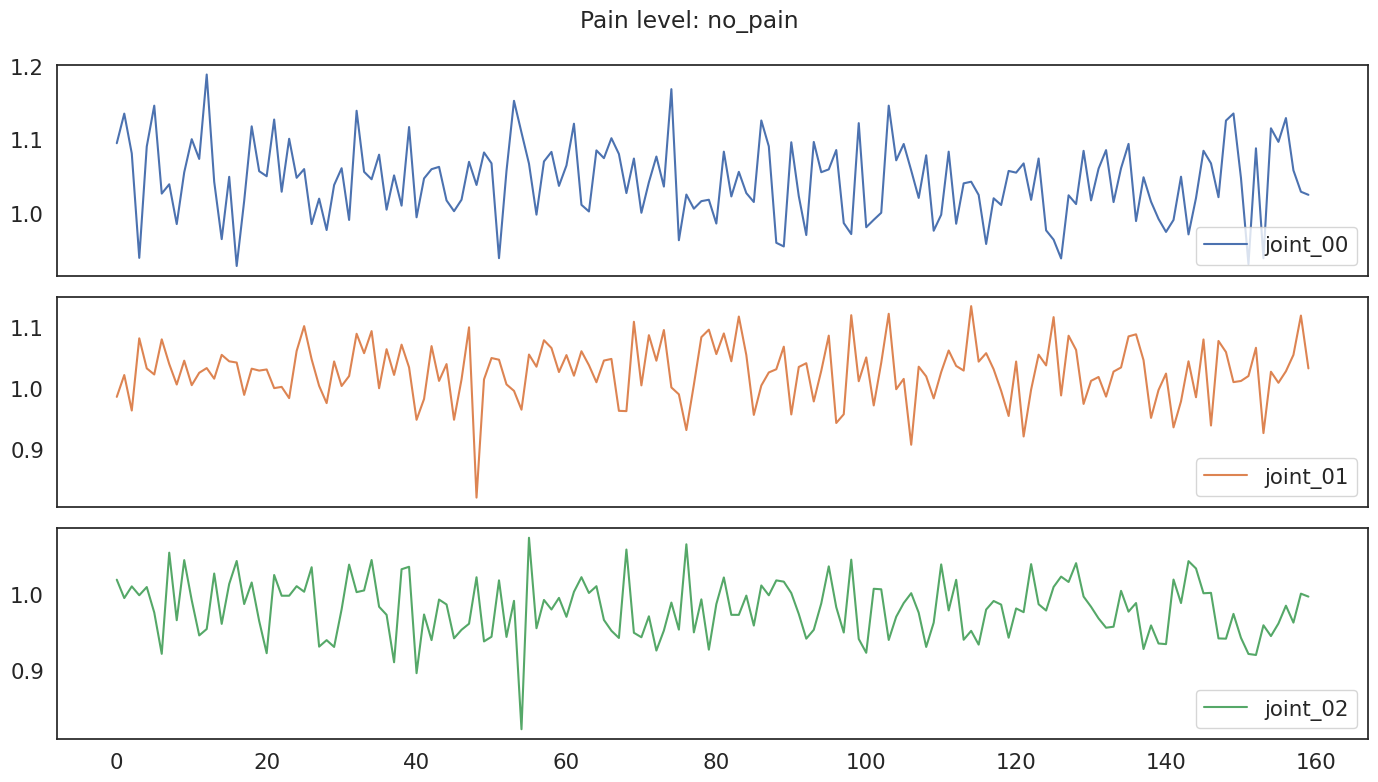

In [178]:
inspect_pain_level("no_pain", df)

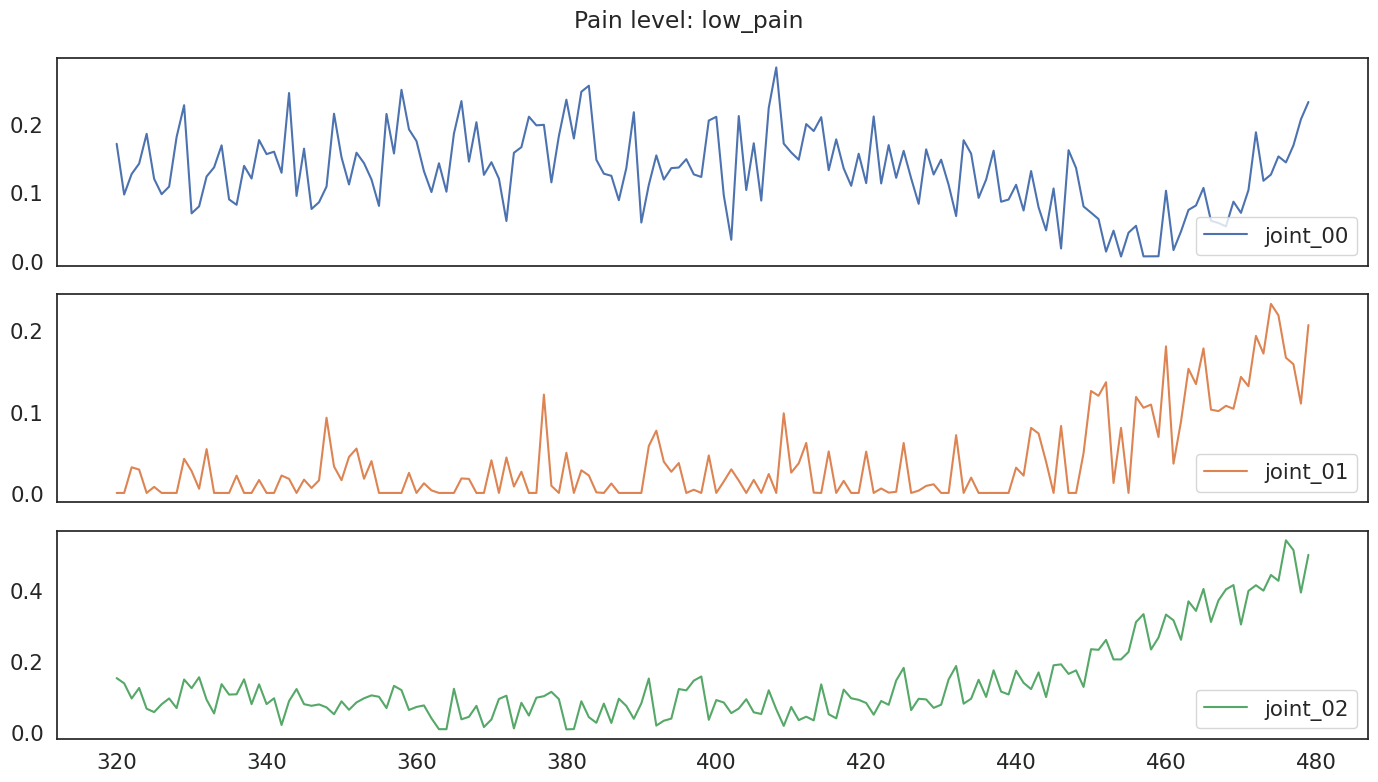

In [179]:
inspect_pain_level("low_pain", df)

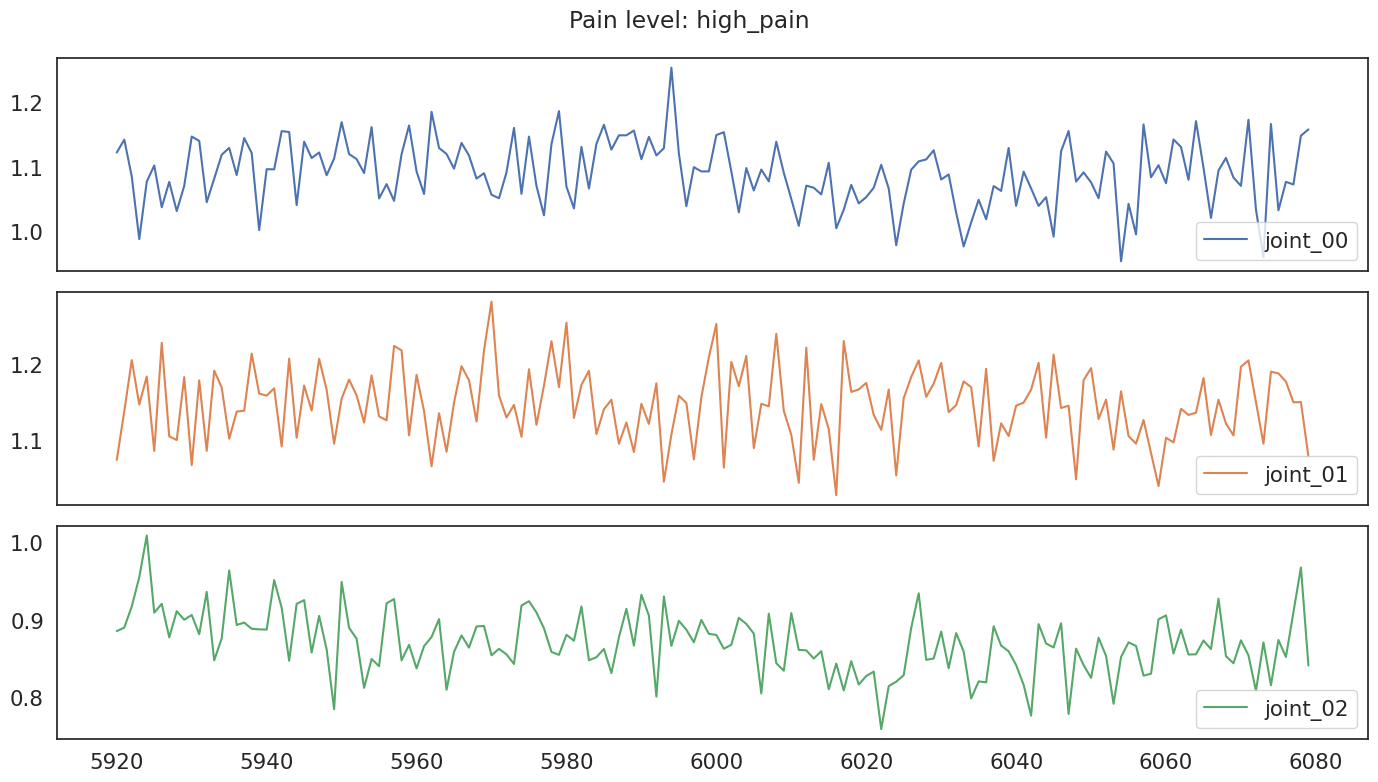

In [180]:
inspect_pain_level("high_pain", df)

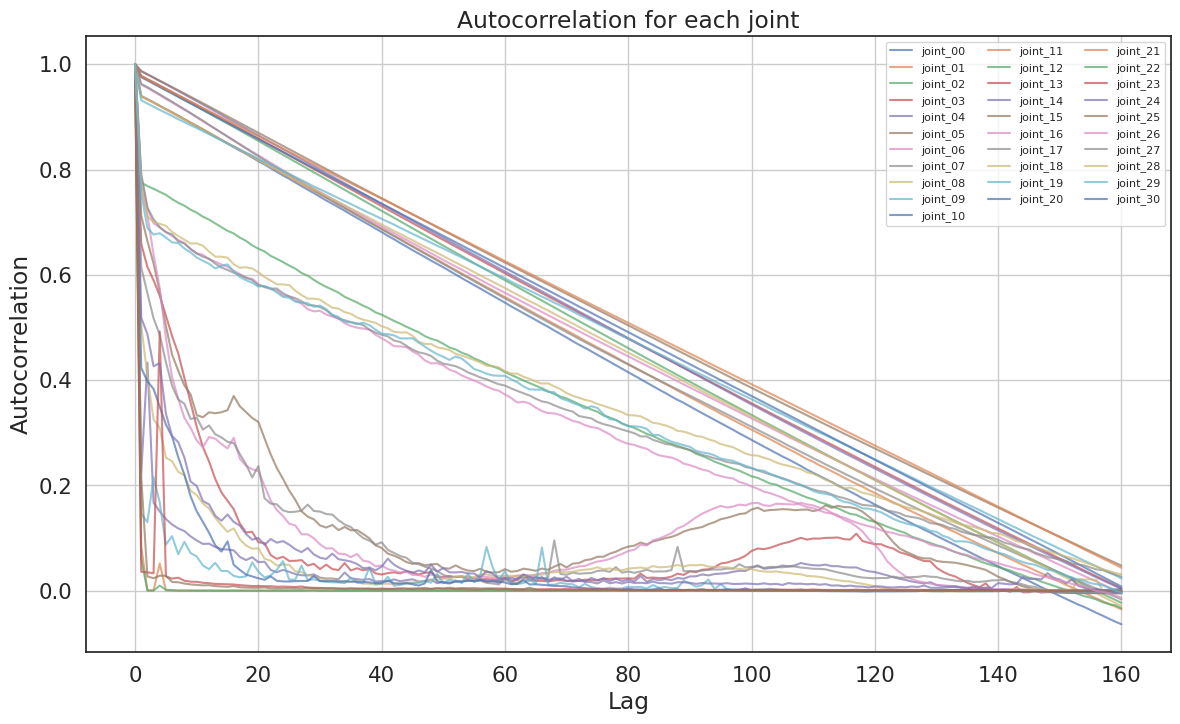

In [181]:
# This block computes and visualises the autocorrelation function (ACF) of each joint signal.
# The idea is:
#   1. Select all sensor columns whose name starts with 'joint_' (each column is a time series).
#   2. For each joint time series, compute the autocorrelation values up to a maximum lag (MAX_LAG).
#      The autocorrelation at lag k measures how similar the signal is to a version of itself shifted by k time steps.
#      Peaks in the ACF can reveal periodicity or characteristic time scales in the motion.
#   3. Plot the ACF curves of all joints on the same figure to compare how quickly they lose correlation over time.
#      This helps to:
#         - choose a reasonable window size (e.g. where the ACF drops or changes behaviour),
#         - understand temporal dependencies in the data,
#         - identify joints with stronger or weaker temporal structure.

from statsmodels.tsa.stattools import acf
# Select all columns starting with 'joint_'
joint_cols = [c for c in df.columns if c.startswith("joint_")]

# Set the maximum lag length (you can change it depending on the window you want to explore)
MAX_LAG = 160

plt.figure(figsize=(14, 8))

# Calcola e traccia l'autocorrelazione per ogni joint
for col in joint_cols:
    acf_values = acf(df[col], nlags=MAX_LAG, fft=True)  # fft=True per velocità
    plt.plot(acf_values, label=col, alpha=0.7)

plt.title("Autocorrelation for each joint")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend(ncol=3, fontsize=8)
plt.grid(True)
plt.show()

## 🔄 **Data Preprocessing**

In [182]:
static_cols = ["n_legs", "n_hands", "n_eyes"]

def process_static_cols(dataframe, columns):
    for c in columns:
        s = dataframe[c]

        # Try to interpret as numeric (if already 1/2, it remains so)
        numeric = pd.to_numeric(s, errors="coerce")

        # For non-numeric values, extract 'one' or 'two' at the beginning (handles 'one+', ' two  ', 'TWO++', etc.)
        needs_parse = numeric.isna()
        parsed = (
            s.astype(str)
             .str.strip().str.lower()
             .str.extract(r'^(one|two)', expand=False)
             .map({"one": 1, "two": 2})
        )

        # Use numeric where available, otherwise the parsed value
        out = numeric.where(~needs_parse, parsed)

        # Assign with compact type
        dataframe[c] = out.astype("Int8")

# Apply the function to df
process_static_cols(df, static_cols)

# Apply the function to df_test_sub
process_static_cols(df_test_sub, static_cols)

# Identify unique activity executions per user by creating a composite ID
df['id'] = df['sample_index'].astype('str') + '_' + df['label'].astype('str')

# Print the number of unique activity executions
print(f'The dataset is composed of {df["id"].nunique()} pirates')

print(n_samples)

The dataset is composed of 661 pirates
661


In [183]:
df.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,id
0,0,0,2,0,2,1,2,2,2,1.094705,...,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain,0_no_pain
1,0,1,2,2,2,2,2,2,2,1.135183,...,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain,0_no_pain
2,0,2,2,0,2,2,2,2,2,1.080745,...,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain,0_no_pain
3,0,3,2,2,2,2,2,2,2,0.938017,...,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain,0_no_pain
4,0,4,2,2,2,2,2,2,2,1.090185,...,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain,0_no_pain


In [184]:
# Display the first five rows of the DataFrame
df_test_sub.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,2,2,2,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,2,2,2,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,2,2,2,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,2,2,2,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,2,2,2,0.805972,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


In [185]:
random.seed(SEED)

# Get unique user IDs and shuffle them
unique_users = df['sample_index'].unique()
random.shuffle(unique_users)

# Calculate the number of users for the training set
n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS

# Split the shuffled user IDs into training, validation, and test sets
train_users = unique_users[:n_train_users]
val_users   = unique_users[n_train_users:n_train_users + N_VAL_USERS]
test_users  = unique_users[n_train_users + N_VAL_USERS:]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)].copy()
df_val   = df[df['sample_index'].isin(val_users)].copy()
df_test  = df[df['sample_index'].isin(test_users)].copy()

print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')
print(f'Test set shape: {df_test.shape}')
print(f'Test set shape (for submission): {df_test_sub.shape}')

# 🔍 Check that there are no pirates in common between sets
train_ids_unique = set(df_train['sample_index'].unique())
val_ids_unique   = set(df_val['sample_index'].unique())

overlap = train_ids_unique.intersection(val_ids_unique)
print("Overlap subjects (train ∩ val):", len(overlap))
assert len(overlap) == 0, "Leakage: stessi pirati in train e val!"

Training set shape: (80160, 42)
Validation set shape: (12800, 42)
Test set shape: (12800, 42)
Test set shape (for submission): (211840, 40)
Overlap subjects (train ∩ val): 0


In [186]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['id'].unique():
    label = df_train[df_train['id'] == id]['label'].values[0]
    training_labels[label] += 1

# Print the distribution of training labels
print('Training labels:', training_labels)

Training labels: {'no_pain': 391, 'low_pain': 69, 'high_pain': 41}


In [187]:
# Initialise a dictionary to count occurrences of each activity in the validation set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the validation set
for id in df_val['id'].unique():
    label = df_val[df_val['id'] == id]['label'].values[0]
    val_labels[label] += 1

# Print the distribution of validation labels
print('Validation labels:', val_labels)

Validation labels: {'no_pain': 59, 'low_pain': 11, 'high_pain': 10}


In [188]:
# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0,
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['id'].unique():
    label = df_test[df_test['id'] == id]['label'].values[0]
    test_labels[label] += 1

# Print the distribution of test labels
print('Test labels:', test_labels)

Test labels: {'no_pain': 61, 'low_pain': 14, 'high_pain': 5}


In [189]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# Map activity names to integers in the test set
df_test['label'] = df_test['label'].map(label_mapping)

In [190]:
# Define the columns to be normalised
scale_columns = [c for c in df_train.columns if c.startswith("joint_")]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    if mins[column] == maxs[column]:
        # Colonna costante → mettila tutta a 0
        df_train[column] = 0.0
        df_val[column] = 0.0
        df_test[column] = 0.0
        df_test_sub[column] = 0.0
    else:
        # Normalise the training set
        df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

        # Normalise the validation set
        df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

        # Normalise the test set
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

        # Normalise the test set for the submission
        df_test_sub[column] = (df_test_sub[column] - mins[column]) / (maxs[column] - mins[column])

In [191]:
# Display the first five rows of the training DataFrame
print(df_val.shape)
df_val.head()

(12800, 42)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,id
0,0,0,2,0,2,1,2,2,2,0.777507,...,0.000015,3.162814e-04,0.000004,0.014211,0.011376,0.018978,0.020291,0.0,0,0_no_pain
1,0,1,2,2,2,2,2,2,2,0.806256,...,0.000022,9.828599e-07,0.000000,0.010745,0.000000,0.009473,0.010006,0.0,0,0_no_pain
2,0,2,2,0,2,2,2,2,2,0.767592,...,0.000005,6.626013e-05,0.000003,0.013093,0.006830,0.017065,0.016856,0.0,0,0_no_pain
3,0,3,2,2,2,2,2,2,2,0.666220,...,0.000007,1.199337e-06,0.000000,0.009502,0.006274,0.020264,0.017981,0.0,0,0_no_pain
4,0,4,2,2,2,2,2,2,2,0.774297,...,0.000006,1.307199e-06,0.000007,0.004212,0.002132,0.023389,0.018477,0.0,0,0_no_pain


In [192]:
print(df_train.shape)
df_train.head()

(80160, 42)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,id
160,1,0,2,1,2,2,2,2,2,0.876159,...,0.000001,0.000002,0.000000e+00,0.031059,0.060058,0.118273,0.051959,0.0,0,1_no_pain
161,1,1,2,2,2,2,2,2,2,0.911081,...,0.000001,0.000048,3.792991e-07,0.034212,0.078148,0.221867,0.079526,0.0,0,1_no_pain
162,1,2,2,2,2,2,2,2,2,0.818209,...,0.000003,0.000068,2.808728e-07,0.023375,0.096336,0.128122,0.042238,0.0,0,1_no_pain
163,1,3,2,2,1,0,2,2,2,0.866563,...,0.000006,0.000002,0.000000e+00,0.010920,0.046604,0.125488,0.061419,0.0,0,1_no_pain
164,1,4,2,2,2,2,2,2,2,0.781053,...,0.000007,0.000002,3.146209e-06,0.042960,0.034286,0.125032,0.060501,0.0,0,1_no_pain


In [193]:
print(df_test.shape)
df_test.head()

(12800, 42)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label,id
960,6,0,2,0,2,2,2,2,2,0.782223,...,0.000001,0.000024,0.000000e+00,0.021901,0.122005,0.031724,0.027406,0.0,0,6_no_pain
961,6,1,2,1,1,2,2,2,2,0.736038,...,0.000010,0.000015,8.248414e-07,0.033009,0.061459,0.033334,0.010245,0.0,0,6_no_pain
962,6,2,2,1,2,1,2,2,2,0.729346,...,0.000001,0.000033,0.000000e+00,0.013963,0.043352,0.047779,0.007958,0.0,0,6_no_pain
963,6,3,2,1,2,2,2,2,2,0.684099,...,0.000008,0.000093,0.000000e+00,0.010596,0.065410,0.019929,0.010055,0.0,0,6_no_pain
964,6,4,2,2,2,2,2,2,2,0.716054,...,0.000001,0.000014,0.000000e+00,0.036198,0.073445,0.016536,0.005775,0.0,0,6_no_pain


In [194]:
print(df_test_sub.shape)
df_test_sub.head()

(211840, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,2,2,2,0.598405,...,0.000002,0.000003,0.000011,0.000093,0.000072,0.015666,0.055856,0.015742,0.009904,0.0
1,0,1,2,2,2,2,2,2,2,0.638393,...,0.000002,0.000003,0.000014,0.000073,0.000031,0.056841,0.067724,0.016749,0.028300,0.0
2,0,2,2,2,2,2,2,2,2,0.680247,...,0.000004,0.000003,0.000035,0.000107,0.000009,0.044761,0.049528,0.019138,0.039542,0.0
3,0,3,1,2,2,2,2,2,2,0.591346,...,0.000003,0.000003,0.000011,0.000109,0.000016,0.039633,0.039690,0.011438,0.018225,0.0
4,0,4,2,2,2,0,2,2,2,0.572436,...,0.000004,0.000003,0.000011,0.000071,0.000009,0.015984,0.026205,0.011061,0.013081,0.0


In [195]:
# Group the 160-timestep sequences by subject
def build_timeseries_per_subject(df):
    subjects = {}
    for sid in df["sample_index"].unique():
        temp = df[df["sample_index"] == sid].sort_values("time")
        X = temp[[c for c in df.columns if c.startswith("joint_")]].values
        y = temp["label"].iloc[0]
        subjects[sid] = (X, y)
    return subjects

subjects = build_timeseries_per_subject(df)

In [196]:
from collections import defaultdict
import numpy as np

classes = ["no_pain", "low_pain", "high_pain"]
class_ts = defaultdict(list)

for sid, (X, y) in subjects.items():
    class_ts[y].append(X)

for c in classes:
    class_ts[c] = np.stack(class_ts[c], axis=0)

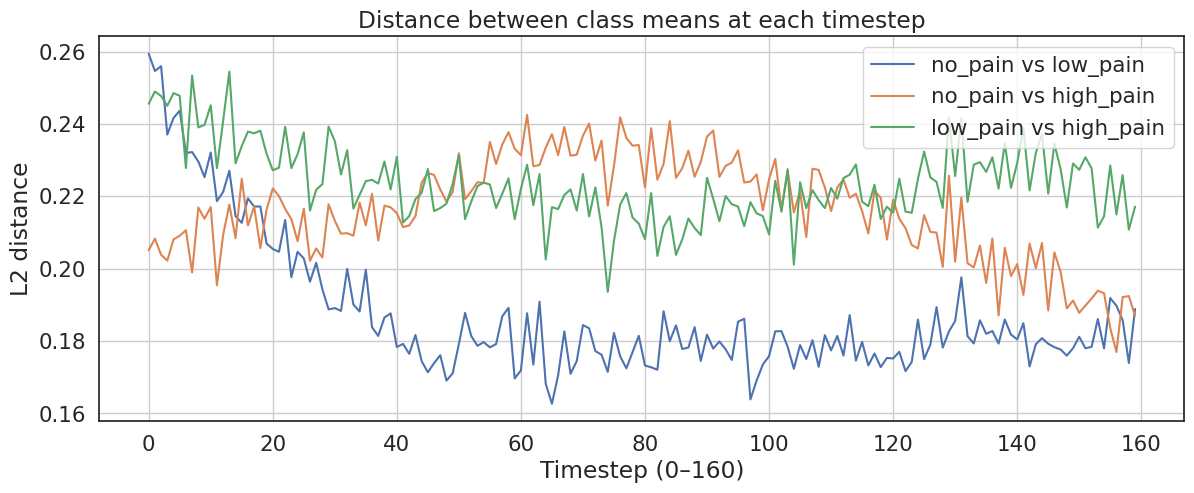

In [197]:
import matplotlib.pyplot as plt

means = {c: class_ts[c].mean(axis=0) for c in classes}

dist_no_low  = np.linalg.norm(means["no_pain"]  - means["low_pain"], axis=1)
dist_no_high = np.linalg.norm(means["no_pain"]  - means["high_pain"], axis=1)
dist_low_high = np.linalg.norm(means["low_pain"] - means["high_pain"], axis=1)

plt.figure(figsize=(14,5))
plt.plot(dist_no_low, label="no_pain vs low_pain")
plt.plot(dist_no_high, label="no_pain vs high_pain")
plt.plot(dist_low_high, label="low_pain vs high_pain")
plt.title("Distance between class means at each timestep")
plt.xlabel("Timestep (0–160)")
plt.ylabel("L2 distance")
plt.legend()
plt.grid(True)
plt.show()

In [198]:
def build_sequences(df, window=160, stride=160):
    # Sanity check: ensure the window size is divisible by stride
    assert window % stride == 0

    dataset = []
    labels = []
    has_labels = 'label' in df.columns  # Check if the dataframe contains labels

    # Label mapping for the Pirate Pain dataset
    label_map = {"no_pain": 0, "low_pain": 1, "high_pain": 2}

    # Static (non–time-varying) features
    static_cols = ["n_legs", "n_hands", "n_eyes"]

    # Sensor columns (all those starting with 'joint_')
    joint_cols = [c for c in df.columns if c.startswith("joint_")]
    if "joint_30" in joint_cols:
        joint_cols.remove("joint_30")  # Constant column (= 0.5), remove it
    if "joint_10" in joint_cols:
        joint_cols.remove("joint_10") # Exclude joint_10 due to joint correlation analysis

    # Additional time-varying pain survey columns
    survey_cols  = [c for c in df.columns if c.startswith("pain_survey_")]
    dynamic_cols = joint_cols + survey_cols

    # Iterate over each subject
    for id in df['sample_index'].unique():
        # Extract all rows corresponding to the current subject
        temp_df = df[df['sample_index'] == id].sort_values("time")

        # Select dynamic (time-varying) features
        temp = temp_df[dynamic_cols].values.astype('float32')

        # --- Add static features as constant columns repeated for the whole sequence
        static_values = temp_df[static_cols].iloc[0].to_numpy(dtype='float32')
        static_block = np.repeat(static_values[None, :], len(temp), axis=0)
        temp = np.concatenate([temp, static_block], axis=1)

        # Process the subject label if available
        if has_labels:
            raw_label = temp_df['label'].iloc[0]

            # Handle both string labels and integer labels
            if isinstance(raw_label, str):
                label = label_map[raw_label]     # Map string → integer class
            else:
                label = raw_label                # Already integer

        # Compute how much padding is needed to complete the last window
        padding_needed = (window - len(temp) % window) % window
        if padding_needed > 0:
            padding = np.zeros((padding_needed, temp.shape[1]), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Sliding window with stride
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            if has_labels:
                labels.append(label)
            idx += stride

    # Convert to numpy arrays
    dataset = np.array(dataset, dtype='float32')

    if has_labels:
        labels = np.array(labels, dtype='int64')
    else:
        # If no labels exist, fill with -1 to keep array lengths consistent
        labels = np.full(len(dataset), -1, dtype='int64')

    return dataset, labels

In [199]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

X_test_sub, y_test_sub = build_sequences(df_test_sub, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_test_sub.shape, y_test_sub.shape

((4509, 32, 36),
 (4509,),
 (720, 32, 36),
 (720,),
 (720, 32, 36),
 (720,),
 (11916, 32, 36),
 (11916,))

In [200]:
def make_subj_ids(df, window, stride):
    """
    Rebuilds the list of sample_index (one per window) and
    the starting timestep of each window, simulating build_sequences.
    This version includes padding logic to match build_sequences.
    """
    ids = []
    starts = []

    for sid in df['sample_index'].unique():
        temp_df_subject = df[df['sample_index'] == sid].sort_values('time')
        n_timesteps_original = len(temp_df_subject)

        # Simulate the padding logic from build_sequences
        padding_needed = (window - n_timesteps_original % window) % window
        n_timesteps_padded = n_timesteps_original + padding_needed

        # Simulate the windowing logic
        idx = 0
        while idx + window <= n_timesteps_padded:
            ids.append(sid)
            starts.append(idx)
            idx += stride

    return np.array(ids), np.array(starts)


#Here we UNPACK: take only the ids and ignore the window starts
subj_ids_train, window_starts_train = make_subj_ids(df_train, WINDOW_SIZE, STRIDE)
subj_ids_val, window_starts_val = make_subj_ids(df_val,   WINDOW_SIZE, STRIDE)

train_ids_unique = np.unique(subj_ids_train)
val_ids_unique   = np.unique(subj_ids_val)

overlap = set(train_ids_unique).intersection(set(val_ids_unique))
print("Overlap subjects (train ∩ val):", len(overlap))
assert len(overlap) == 0, "Leakage: stessi pirati in train e val!"

Overlap subjects (train ∩ val): 0


In [201]:
# --- Ricrea subj_ids per ogni finestra del test set --- #
# Using the corrected make_subj_ids function to ensure consistency
subj_ids, windows_starts = make_subj_ids(df, WINDOW_SIZE, STRIDE)

print(f"subj_ids shape: {subj_ids.shape} | unique pirates: {len(np.unique(subj_ids))}")

subj_ids shape: (5949,) | unique pirates: 661


In [202]:
print("y_train:", pd.Series(y_train).value_counts())
print("y_val:  ", pd.Series(y_val).value_counts())
print("y_test: ", pd.Series(y_test).value_counts())
print("y_test_sub:", pd.Series(y_test_sub).value_counts())

y_train: 0    3519
1     621
2     369
Name: count, dtype: int64
y_val:   0    531
1     99
2     90
Name: count, dtype: int64
y_test:  0    549
1    126
2     45
Name: count, dtype: int64
y_test_sub: -1    11916
Name: count, dtype: int64


In [203]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [204]:
#assess the misproportion among classes:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
print(classes)

weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

cw = 1 + (weights - 1) * beta

# Set up loss function with class weights
class_weights = torch.tensor(cw, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

print(f"Classes: {classes}")
print(f"Computed weights: {cw}")

[0 1 2]
Classes: [0 1 2]
Computed weights: [0.42710997 2.42028986 4.07317073]


In [205]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_ds_sub = TensorDataset(torch.from_numpy(X_test_sub), torch.from_numpy(y_test_sub))

In [206]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [207]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_sub_loader  = make_loader(test_ds_sub, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [208]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([64, 32, 36])
Labels batch shape: torch.Size([64])


## 🛠️ **Model Building**

In [209]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [210]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2 #dropout puts to 0 20% of h(t)
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 32, 128], [2, -1, 128]] 54,272         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,659
Trainable params: 54,659
Non-trainable params: 0
-------------------------------------------------------------------------------


## 🧠 **Model Training**

In [211]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [212]:
def compute_window_weights(window_starts, window_size,
                           imp_start=None,
                           imp_end=None,
                           alpha=1,
                           spans=None,
                           alphas=None):
    """
    Compute a weight for each window based on how much it overlaps
    with one or more important time regions.

    Parameters
    ----------
    window_starts : np.ndarray
        Array of starting timesteps for each window.
    window_size : int
        Length of each window in timesteps.
    imp_start, imp_end : int or None
        Backward-compatible way to specify a single important interval
        [imp_start, imp_end). If provided and ``spans`` is None,
        they are used to build ``spans = [(imp_start, imp_end)]``.
    alpha : float
        Default boost factor applied to windows overlapping important regions
        when per-span alphas are not provided.
    spans : list of (int, int), optional
        List of important intervals [start, end) in timesteps.
        Useful if you want to give more weight to multiple periods,
        e.g. [(0, 20), (80, 100)].
    alphas : list of float, optional
        Per-span boost factors. Must have the same length as ``spans``.
        Example: spans=[(0, 20), (80, 100)], alphas=[2.0, 1.75].

    Returns
    -------
    weights : np.ndarray of shape (n_windows,)
        Weight for each window (>= 1.0).
    """
    # Decide which intervals to use
    if spans is None:
        if imp_start is not None and imp_end is not None:
            spans = [(imp_start, imp_end)]
        else:
            spans = IMPORTANT_SPANS  # global default list of intervals

    # If no per-span alphas provided, use the same alpha for all spans
    if alphas is None:
        alphas = [alpha] * len(spans)
    else:
        if len(alphas) != len(spans):
            raise ValueError("`alphas` must have the same length as `spans`.")

    window_starts = np.asarray(window_starts)
    window_ends   = window_starts + window_size

    # Start from weight 1 for every window
    weights = np.ones_like(window_starts, dtype=np.float32)

    # Add contribution from each important interval
    for (s, e), a in zip(spans, alphas):
        # overlap length between [start, end) and [s, e)
        overlap_start = np.maximum(window_starts, s)
        overlap_end   = np.minimum(window_ends, e)
        overlap = np.maximum(0, overlap_end - overlap_start)

        # Fraction of window that lies inside [s, e)
        frac = overlap / float(window_size)

        # Increase weight proportionally
        weights += a * frac

    return weights


In [213]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            # Modified line: Unpack logits and discard attention weights
            model_output = model(inputs)
            if isinstance(model_output, tuple):
                logits, _ = model_output
            else:
                logits = model_output
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [214]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [215]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [216]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Bidirectional Gated Recurrent Unit (BiGRU)**

<img src="https://drive.google.com/uc?export=view&id=1KH9dzVdNpSftSvWb2IXkBNcXAWwWVdhw" width="800"/>

In [217]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='GRU',
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_gru_attention"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 32, 256], [4, -1, 128]] 423,936        
classifier (Linear)       [-1, 3]                      771            
Total params: 424,707
Trainable params: 424,707
Non-trainable params: 0
-------------------------------------------------------------------------------


In [218]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_gru_attention", # Updated experiment name
    patience=PATIENCE # Use the global PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0634, F1 Score=0.5537 | Val: Loss=0.9245, F1 Score=0.6582
Epoch   2/500 | Train: Loss=0.9874, F1 Score=0.6680 | Val: Loss=0.9513, F1 Score=0.6808
Epoch   3/500 | Train: Loss=0.9127, F1 Score=0.6788 | Val: Loss=0.8932, F1 Score=0.7792
Epoch   4/500 | Train: Loss=0.7998, F1 Score=0.7577 | Val: Loss=0.8630, F1 Score=0.7768
Epoch   5/500 | Train: Loss=0.7204, F1 Score=0.7985 | Val: Loss=0.8002, F1 Score=0.7972
Epoch   6/500 | Train: Loss=0.6760, F1 Score=0.8175 | Val: Loss=0.7433, F1 Score=0.8120
Epoch   7/500 | Train: Loss=0.5968, F1 Score=0.8460 | Val: Loss=0.7739, F1 Score=0.7595
Epoch   8/500 | Train: Loss=0.6046, F1 Score=0.8333 | Val: Loss=0.7818, F1 Score=0.7871
Epoch   9/500 | Train: Loss=0.5131, F1 Score=0.8425 | Val: Loss=0.6581, F1 Score=0.7669
Epoch  10/500 | Train: Loss=0.5318, F1 Score=0.8463 | Val: Loss=0.6202, F1 Score=0.7712
Epoch  11/500 | Train: Loss=0.4905, F1 Score=0.8500 | Val: Loss=0.6422, F1 Score=0.8199
Epoch  12

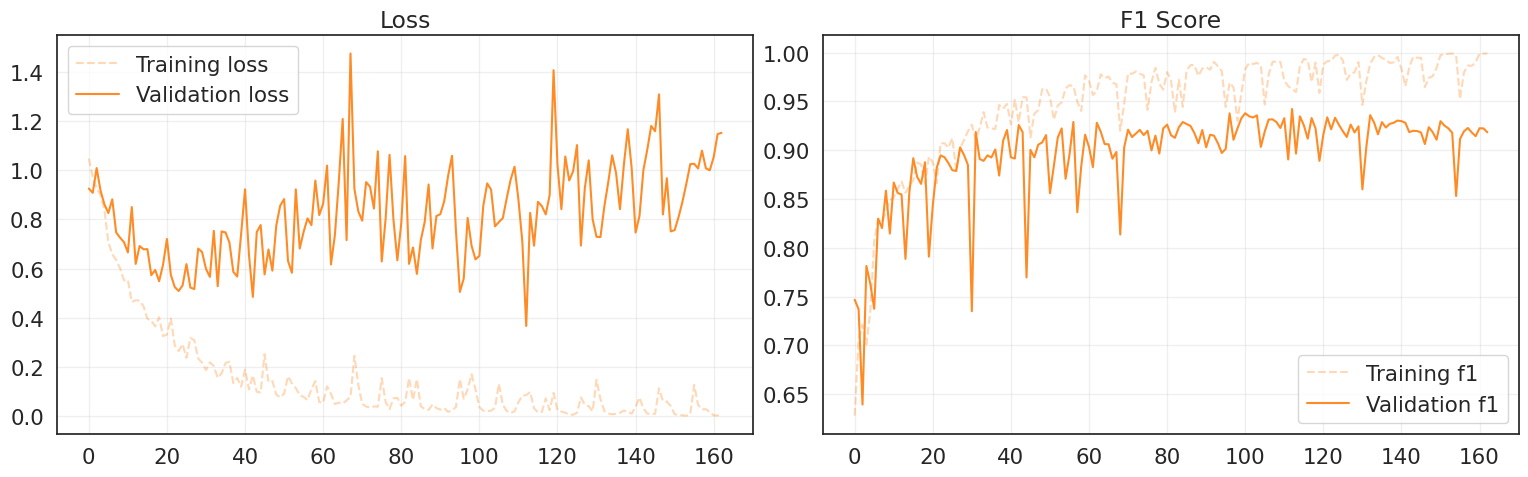

In [229]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

=== Validation — Per Window ===
Accuracy:  0.9431
Precision: 0.9432
Recall:    0.9431
F1 score:  0.9422


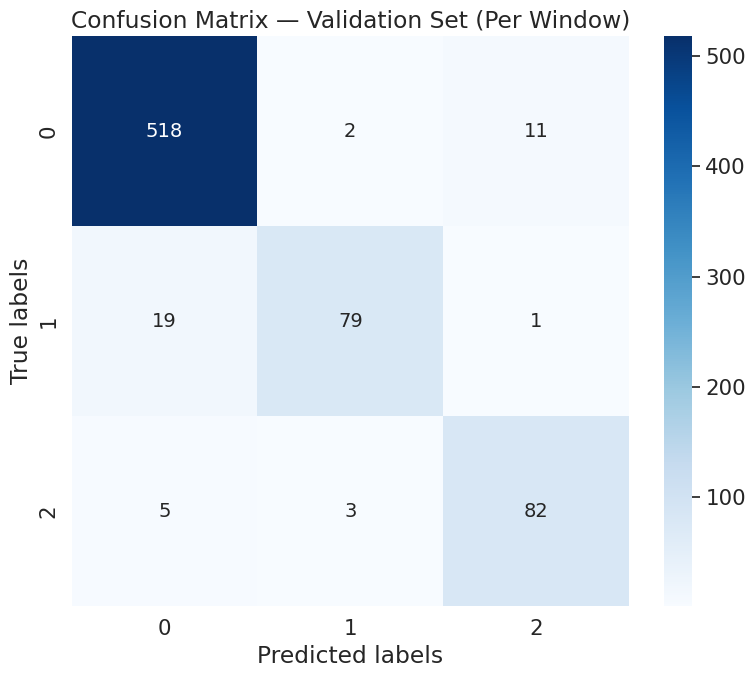

subj_ids_val: (720,) | window_starts_val: (720,)

=== Validation — Aggregated by Subject (weighted windows) ===
Accuracy:  0.9750
Precision: 0.9761
Recall:    0.9750
F1 score:  0.9750


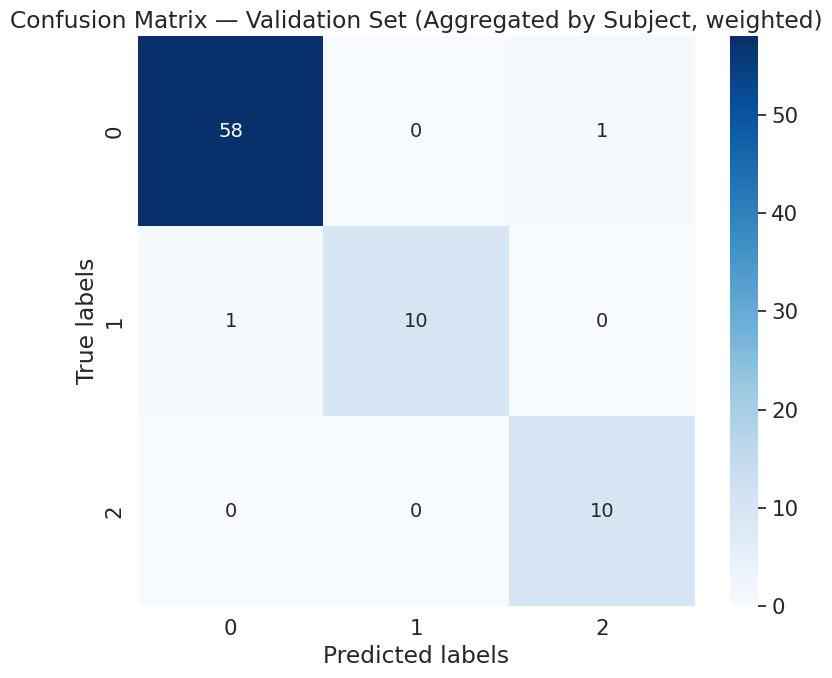

In [235]:
rnn_model.eval()

val_probs_list = []
val_targets_list = []

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model logits
        logits = rnn_model(xb)

        # Probabilities from softmax (used later for aggregation)
        probs = torch.softmax(logits, dim=1)

        # Save batch probabilities and targets
        val_probs_list.append(probs.cpu().numpy())
        val_targets_list.append(yb.numpy())

# Combine all batches into single arrays
val_probs   = np.concatenate(val_probs_list, axis=0)   # shape: (N_windows, C)
val_targets = np.concatenate(val_targets_list, axis=0) # shape: (N_windows,)

# ===============================
# 1) CONFUSION MATRIX BY WINDOW
# ===============================

# Predictions by window
val_preds_window = val_probs.argmax(axis=1)

# Metrics computed per window
val_acc_w  = accuracy_score(val_targets, val_preds_window)
val_prec_w = precision_score(val_targets, val_preds_window, average='weighted')
val_rec_w  = recall_score(val_targets, val_preds_window, average='weighted')
val_f1_w   = f1_score(val_targets, val_preds_window, average='weighted')

print("=== Validation — Per Window ===")
print(f"Accuracy:  {val_acc_w:.4f}")
print(f"Precision: {val_prec_w:.4f}")
print(f"Recall:    {val_rec_w:.4f}")
print(f"F1 score:  {val_f1_w:.4f}")

# Confusion matrix per window
cm_window = confusion_matrix(val_targets, val_preds_window)
labels_window = np.array([f"{num}" for num in cm_window.flatten()]).reshape(cm_window.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_window, annot=labels_window, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Per Window)')
plt.tight_layout()
plt.show()

# ===========================================
# 2) CONFUSION MATRIX AGGREGATED BY SUBJECT (WEIGHTED AVERAGE)
# ===========================================

# Generate subject IDs and starting timestep of each window in the validation set
subj_ids_val, window_starts_val = make_subj_ids(df_val, WINDOW_SIZE, STRIDE)
print("subj_ids_val:", subj_ids_val.shape, "| window_starts_val:", window_starts_val.shape)

assert len(subj_ids_val) == len(val_targets), \
       "subj_ids_val must have the same length as val_targets!"

# Compute weights for each validation window
val_window_weights = compute_window_weights(
    window_starts_val,
    window_size=WINDOW_SIZE,
    spans=IMPORTANT_SPANS,
    alphas=IMPORTANT_ALPHAS
)

unique_ids = np.unique(subj_ids_val)
final_preds, final_targets = [], []

for sid in unique_ids:
    mask = (subj_ids_val == sid)

    probs_sid   = val_probs[mask]
    weights_sid = val_window_weights[mask]

    y_true_sid = val_targets[mask][0]

    # ------- WEIGHTED AVERAGE OF PROBABILITIES -------
    w = weights_sid[:, None]
    probs_agg = (probs_sid * w).sum(axis=0) / w.sum()

    y_pred_sid = np.argmax(probs_agg)

    final_preds.append(y_pred_sid)
    final_targets.append(y_true_sid)

final_preds   = np.array(final_preds)
final_targets = np.array(final_targets)

# Global metrics computed per subject
val_acc_s  = accuracy_score(final_targets, final_preds)
val_prec_s = precision_score(final_targets, final_preds, average='weighted')
val_rec_s  = recall_score(final_targets, final_preds, average='weighted')
val_f1_s   = f1_score(final_targets, final_preds, average='weighted')

print("\n=== Validation — Aggregated by Subject (weighted windows) ===")
print(f"Accuracy:  {val_acc_s:.4f}")
print(f"Precision: {val_prec_s:.4f}")
print(f"Recall:    {val_rec_s:.4f}")
print(f"F1 score:  {val_f1_s:.4f}")

# Confusion matrix per subject
cm_subj = confusion_matrix(final_targets, final_preds)
labels_subj = np.array([f"{num}" for num in cm_subj.flatten()]).reshape(cm_subj.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_subj, annot=labels_subj, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Aggregated by Subject, weighted)')
plt.tight_layout()
plt.show()


Config: baseline_equal
  spans:  []
  alphas: []
  Accuracy:  0.9375
  Precision: 0.9369
  Recall:    0.9375
  F1 score:  0.9370

Config: early_strong
  spans:  [(0, 40)]
  alphas: [2.0]
  Accuracy:  0.9500
  Precision: 0.9508
  Recall:    0.9500
  F1 score:  0.9466

Config: early+middle
  spans:  [(0, 40), (60, 100)]
  alphas: [2.0, 1.75]
  Accuracy:  0.9375
  Precision: 0.9340
  Recall:    0.9375
  F1 score:  0.9339

Config: early+middle+late
  spans:  [(0, 40), (60, 100), (130, 159)]
  alphas: [2.0, 1.75, 1.5]
  Accuracy:  0.9500
  Precision: 0.9467
  Recall:    0.9500
  F1 score:  0.9474

Config: middle_focus
  spans:  [(60, 100)]
  alphas: [2.0]
  Accuracy:  0.9500
  Precision: 0.9467
  Recall:    0.9500
  F1 score:  0.9474

 BEST CONFIGURATION ON TEST SET
Name:   early+middle+late
Spans:  [(0, 40), (60, 100), (130, 159)]
Alphas: [2.0, 1.75, 1.5]
Best F1 (test): 0.9474


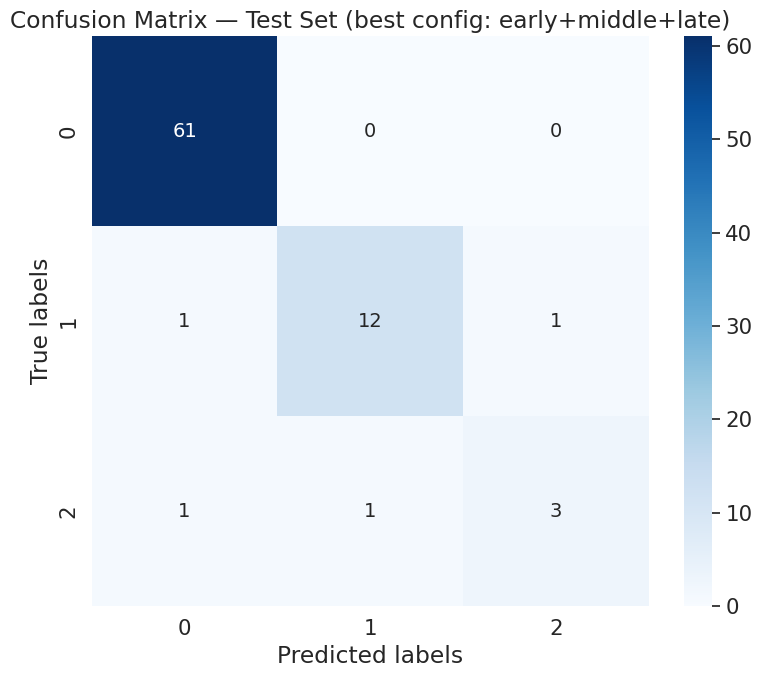

In [232]:
if N_TEST_USERS > 0:
    # @title Grid search over window weights — Test Set (Aggregated by Subject, weighted)

    rnn_model.eval()
    test_preds = []

    # 1️⃣ Forward pass on the test set (done once)
    with torch.no_grad():
        for i in range(0, len(X_test), 256):   # you can change the batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)       # shape: (N_windows, C)

    # Subject IDs and starting index of each window
    subj_ids_test, window_starts_test = make_subj_ids(
        df_test, WINDOW_SIZE, STRIDE
    )

    assert len(subj_ids_test) == len(test_preds) == len(y_test), \
        "subj_ids_test, test_preds and y_test must have the same length!"

    unique_ids = np.unique(subj_ids_test)

    grid_configs = [
        {
            "name": "baseline_equal",
            "spans": [],                     # no special intervals → all weights = 1
            "alphas": []
        },
        {
            "name": "early_strong",
            "spans": [(0, 40)],
            "alphas": [2.0]
        },
        {
            "name": "early+middle",
            "spans": [(0, 40), (60, 100)],
            "alphas": [2.0, 1.75]
        },
        {
            "name": "early+middle+late",
            "spans": [(0, 40), (60, 100), (130, 159)],
            "alphas": [2.0, 1.75, 1.5]
        },
        {
            "name": "middle_focus",
            "spans": [(60, 100)],
            "alphas": [2.0]
        }
    ]

    best_f1   = -1
    best_conf = None
    all_results = []

    # 4️⃣ Loop over all configurations
    for cfg in grid_configs:
        spans  = cfg["spans"]
        alphas = cfg["alphas"]

        if len(spans) == 0:
            # No special intervals → all weights = 1.0
            test_window_weights = np.ones_like(window_starts_test, dtype=float)
        else:
            test_window_weights = compute_window_weights(
                window_starts_test,
                window_size=WINDOW_SIZE,
                spans=spans,
                alphas=alphas
            )

        final_preds, final_targets = [], []

        for sid in unique_ids:
            mask = (subj_ids_test == sid)

            probs_sid   = test_preds[mask]              # shape: (N_windows_subject, C)
            weights_sid = test_window_weights[mask]     # shape: (N_windows_subject,)
            # Same label for all windows of the same subject
            y_true_sid  = y_test[mask][0]

            # ------- WEIGHTED AVERAGE OF PROBABILITIES -------
            w = weights_sid[:, None]                    # shape: (N_windows_subject, 1)
            probs_agg = (probs_sid * w).sum(axis=0) / w.sum()
            y_pred_sid = np.argmax(probs_agg)

            final_preds.append(y_pred_sid)
            final_targets.append(y_true_sid)

        final_preds   = np.array(final_preds)
        final_targets = np.array(final_targets)

        # --- Global metrics ---
        test_acc  = accuracy_score(final_targets, final_preds)
        test_prec = precision_score(final_targets, final_preds, average='weighted')
        test_rec  = recall_score(final_targets, final_preds, average='weighted')
        test_f1   = f1_score(final_targets, final_preds, average='weighted')

        all_results.append({
            "name": cfg["name"],
            "spans": spans,
            "alphas": alphas,
            "acc": test_acc,
            "prec": test_prec,
            "rec": test_rec,
            "f1": test_f1
        })

        print(f"\nConfig: {cfg['name']}")
        print(f"  spans:  {spans}")
        print(f"  alphas: {alphas}")
        print(f"  Accuracy:  {test_acc:.4f}")
        print(f"  Precision: {test_prec:.4f}")
        print(f"  Recall:    {test_rec:.4f}")
        print(f"  F1 score:  {test_f1:.4f}")

        if test_f1 > best_f1:
            best_f1   = test_f1
            best_conf = (cfg, final_targets.copy(), final_preds.copy())

    # 5️⃣ Print the best configuration
    print("\n==============================")
    print(" BEST CONFIGURATION ON TEST SET")
    print("==============================")
    print(f"Name:   {best_conf[0]['name']}")
    print(f"Spans:  {best_conf[0]['spans']}")
    print(f"Alphas: {best_conf[0]['alphas']}")
    print(f"Best F1 (test): {best_f1:.4f}")

    # 6️⃣ Confusion matrix of the best configuration
    best_targets = best_conf[1]
    best_preds   = best_conf[2]

    cm = confusion_matrix(best_targets, best_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix — Test Set (best config: {best_conf[0]["name"]})')
    plt.tight_layout()
    plt.show()

else:
    print(f"Skipping Test Set Confusion Matrix as N_TEST_USERS is {N_TEST_USERS}")

In [234]:
# @title Generate Submission File for X_test_sub (weighted windows)

# Ensure the model is in evaluation mode
rnn_model.eval()

# Rebuild X_test_sub and y_test_sub with the current global WINDOW_SIZE and STRIDE
# This ensures consistency with how subj_ids_sub is generated
X_test_sub, y_test_sub = build_sequences(df_test_sub, WINDOW_SIZE, STRIDE)

# ---- 1) Forward pass on all windows of X_test_sub ----

test_sub_window_preds = []

with torch.no_grad():
    for i in range(0, len(X_test_sub), 256):  # batch size 256 for inference
        xb = torch.tensor(X_test_sub[i:i+256], dtype=torch.float32, device=device)

        logits = rnn_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        test_sub_window_preds.append(probs)

test_sub_window_preds = np.concatenate(test_sub_window_preds, axis=0)  # shape: (N_windows, num_classes)

# ---- 2) Reconstruct subj_ids and window_starts for df_test_sub ----

subj_ids_sub, window_starts_sub = make_subj_ids(
    df_test_sub,
    window=WINDOW_SIZE,
    stride=STRIDE
)

print("subj_ids_sub:", subj_ids_sub.shape,
      "| window_starts_s:", window_starts_s.shape,
      "| preds:", test_sub_window_preds.shape)

assert len(subj_ids_sub) == len(test_sub_window_preds), \
    "subj_ids_sub and test_sub_window_preds must have the same length!"

# ---- 3) Compute window weights (larger if the window covers important spans) ----

window_weights_s = compute_window_weights(
    window_starts_s,
    window_size=WINDOW_SIZE,
    spans=IMPORTANT_SPANS,
    alphas=IMPORTANT_ALPHAS
)

# ---- 4) Aggregation per subject with weighted average ----

unique_sample_indices = np.unique(subj_ids_sub)

final_predictions = []

for sid in unique_sample_indices:
    # Mask for all windows belonging to this subject
    mask = (subj_ids_sub == sid)

    probs_for_subject   = test_sub_window_preds[mask]     # shape: (W_sub, num_classes)
    weights_for_subject = window_weights_s[mask]        # shape: (W_sub,)

    # Normalise weights so they sum to 1
    w = weights_for_subject[:, None]                    # shape: (W_sub, 1)
    weighted_probs = (probs_for_subject * w).sum(axis=0) / w.sum()

    predicted_label_index = int(np.argmax(weighted_probs))

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# ---- 5) Build the submission DataFrame ----

submission_df = pd.DataFrame(final_predictions)

inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

submission_file_path = os.path.join(
    current_dir.replace('\\', ''),
    'submission_grubi_weighted.csv'
)

submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

subj_ids_sub: (11916,) | window_starts_s: (11916,) | preds: (11916, 3)
Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_grubi_weighted.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


### **Gated Recurrent Unit (GRU)**

<img src="https://drive.google.com/uc?export=view&id=1Ux7kRpO_9zgPfxITPjAsRZEOuVcJZVgg" width="1000"/>

In [236]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='GRU'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "gru"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 32, 128], [2, -1, 128]] 162,816        
classifier (Linear)       [-1, 3]                      387            
Total params: 163,203
Trainable params: 163,203
Non-trainable params: 0
-------------------------------------------------------------------------------


In [237]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="gru",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0273, F1 Score=0.6552 | Val: Loss=1.0761, F1 Score=0.2721
Epoch   2/500 | Train: Loss=0.9502, F1 Score=0.6697 | Val: Loss=0.8844, F1 Score=0.7596
Epoch   3/500 | Train: Loss=0.9395, F1 Score=0.6797 | Val: Loss=0.9889, F1 Score=0.7693
Epoch   4/500 | Train: Loss=0.8631, F1 Score=0.7061 | Val: Loss=0.9172, F1 Score=0.5548
Epoch   5/500 | Train: Loss=0.8160, F1 Score=0.7395 | Val: Loss=0.9676, F1 Score=0.7673
Epoch   6/500 | Train: Loss=0.7615, F1 Score=0.7654 | Val: Loss=0.9125, F1 Score=0.7840
Epoch   7/500 | Train: Loss=0.6815, F1 Score=0.8173 | Val: Loss=0.8213, F1 Score=0.7306
Epoch   8/500 | Train: Loss=0.6449, F1 Score=0.8167 | Val: Loss=0.9651, F1 Score=0.7511
Epoch   9/500 | Train: Loss=0.6498, F1 Score=0.8142 | Val: Loss=0.8238, F1 Score=0.8049
Epoch  10/500 | Train: Loss=0.5884, F1 Score=0.8345 | Val: Loss=0.8068, F1 Score=0.6079
Epoch  11/500 | Train: Loss=0.5961, F1 Score=0.8157 | Val: Loss=0.7839, F1 Score=0.7291
Epoch  12

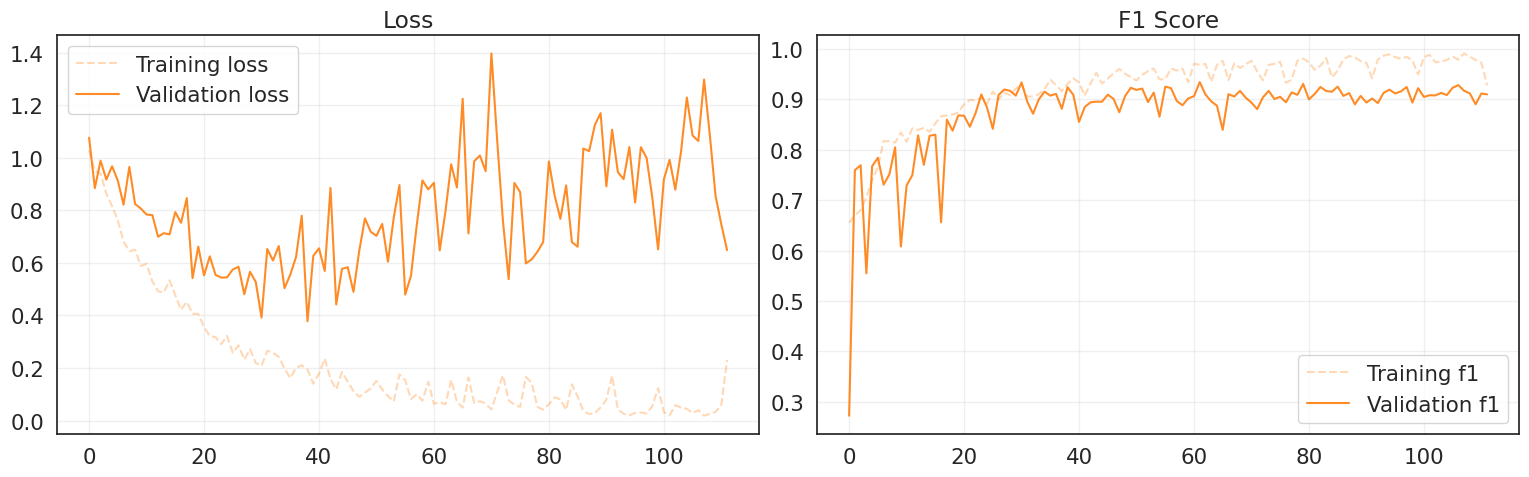

In [242]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

=== Validation — Per Window ===
Accuracy:  0.9347
Precision: 0.9341
Recall:    0.9347
F1 score:  0.9343


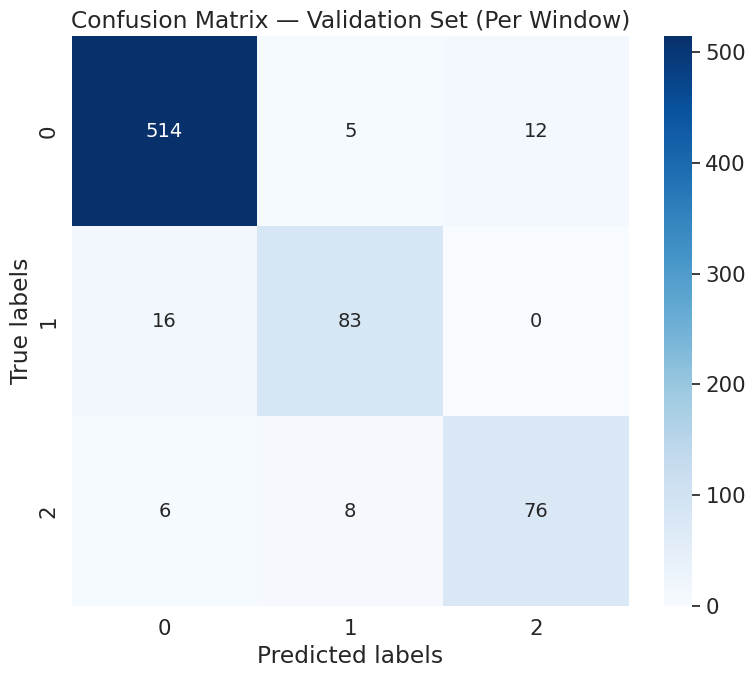

subj_ids_val: (720,) | window_starts_val: (720,)

=== Validation — Aggregated by Subject (weighted windows) ===
Accuracy:  0.9375
Precision: 0.9361
Recall:    0.9375
F1 score:  0.9360


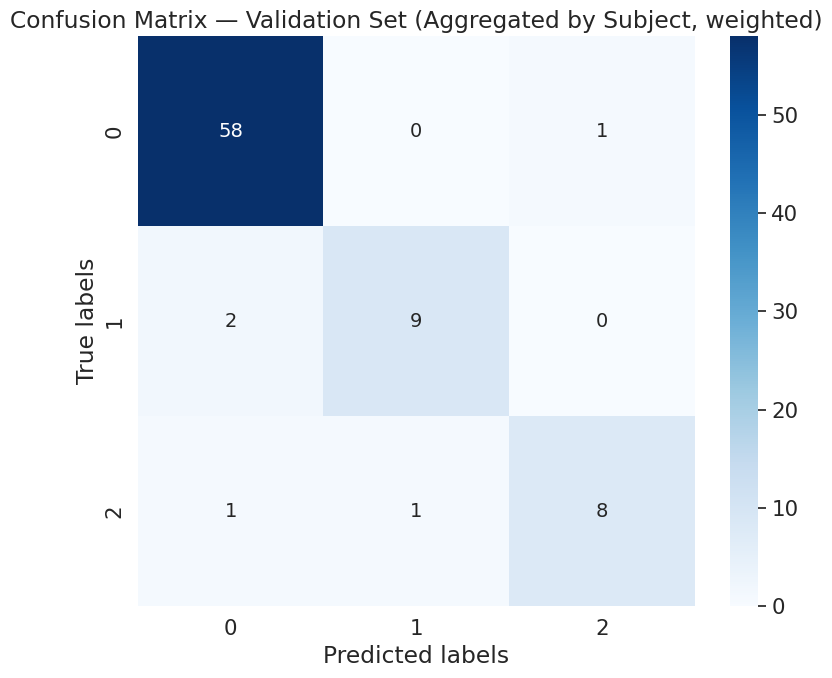

In [243]:
# @title Plot Confusion Matrices — Validation Set (Per Window & Aggregated by Subject)

rnn_model.eval()

val_probs_list = []
val_targets_list = []

with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model logits
        logits = rnn_model(xb)

        # Probabilities from softmax (for aggregation)
        probs = torch.softmax(logits, dim=1)

        # Save batch of probabilities and targets
        val_probs_list.append(probs.cpu().numpy())
        val_targets_list.append(yb.numpy())

# Combine all batches into single arrays
val_probs   = np.concatenate(val_probs_list, axis=0)   # shape: (N_windows, C)
val_targets = np.concatenate(val_targets_list, axis=0) # shape: (N_windows,)

# ===============================
# 1) CONFUSION MATRIX BY WINDOW
# ===============================

# Predictions per window
val_preds_window = val_probs.argmax(axis=1)

# Metrics computed per window
val_acc_w  = accuracy_score(val_targets, val_preds_window)
val_prec_w = precision_score(val_targets, val_preds_window, average='weighted')
val_rec_w  = recall_score(val_targets, val_preds_window, average='weighted')
val_f1_w   = f1_score(val_targets, val_preds_window, average='weighted')

print("=== Validation — Per Window ===")
print(f"Accuracy:  {val_acc_w:.4f}")
print(f"Precision: {val_prec_w:.4f}")
print(f"Recall:    {val_rec_w:.4f}")
print(f"F1 score:  {val_f1_w:.4f}")

# Confusion matrix per window
cm_window = confusion_matrix(val_targets, val_preds_window)
labels_window = np.array([f"{num}" for num in cm_window.flatten()]).reshape(cm_window.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_window, annot=labels_window, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Per Window)')
plt.tight_layout()
plt.show()

# ===========================================
# 2) CONFUSION MATRIX AGGREGATED BY SUBJECT (WEIGHTED AVERAGE)
# ===========================================

# Generate subject IDs and starting timestep for each window in the validation set
subj_ids_val, window_starts_val = make_subj_ids(df_val, WINDOW_SIZE, STRIDE)
print("subj_ids_val:", subj_ids_val.shape, "| window_starts_val:", window_starts_val.shape)

assert len(subj_ids_val) == len(val_targets), \
       "subj_ids_val must have the same length as val_targets!"

# Compute weights for each validation window
val_window_weights = compute_window_weights(
    window_starts_val,
    window_size=WINDOW_SIZE,
    spans=IMPORTANT_SPANS,
    alphas=IMPORTANT_ALPHAS
)

unique_ids = np.unique(subj_ids_val)
final_preds, final_targets = [], []

for sid in unique_ids:
    mask = (subj_ids_val == sid)

    probs_sid   = val_probs[mask]
    weights_sid = val_window_weights[mask]

    y_true_sid = val_targets[mask][0]

    # ------- WEIGHTED AVERAGE OF PROBABILITIES -------
    w = weights_sid[:, None]
    probs_agg = (probs_sid * w).sum(axis=0) / w.sum()

    y_pred_sid = np.argmax(probs_agg)

    final_preds.append(y_pred_sid)
    final_targets.append(y_true_sid)

final_preds   = np.array(final_preds)
final_targets = np.array(final_targets)

# Global metrics computed per subject
val_acc_s  = accuracy_score(final_targets, final_preds)
val_prec_s = precision_score(final_targets, final_preds, average='weighted')
val_rec_s  = recall_score(final_targets, final_preds, average='weighted')
val_f1_s   = f1_score(final_targets, final_preds, average='weighted')

print("\n=== Validation — Aggregated by Subject (weighted windows) ===")
print(f"Accuracy:  {val_acc_s:.4f}")
print(f"Precision: {val_prec_s:.4f}")
print(f"Recall:    {val_rec_s:.4f}")
print(f"F1 score:  {val_f1_s:.4f}")

# Confusion matrix per subject
cm_subj = confusion_matrix(final_targets, final_preds)
labels_subj = np.array([f"{num}" for num in cm_subj.flatten()]).reshape(cm_subj.shape)

plt.figure(figsize=(8, 7))
sns.heatmap(cm_subj, annot=labels_subj, fmt='', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set (Aggregated by Subject, weighted)')
plt.tight_layout()
plt.show()

Accuracy over the test set: 0.9375
Precision over the test set: 0.9396
Recall over the test set: 0.9375
F1 score over the test set: 0.9296


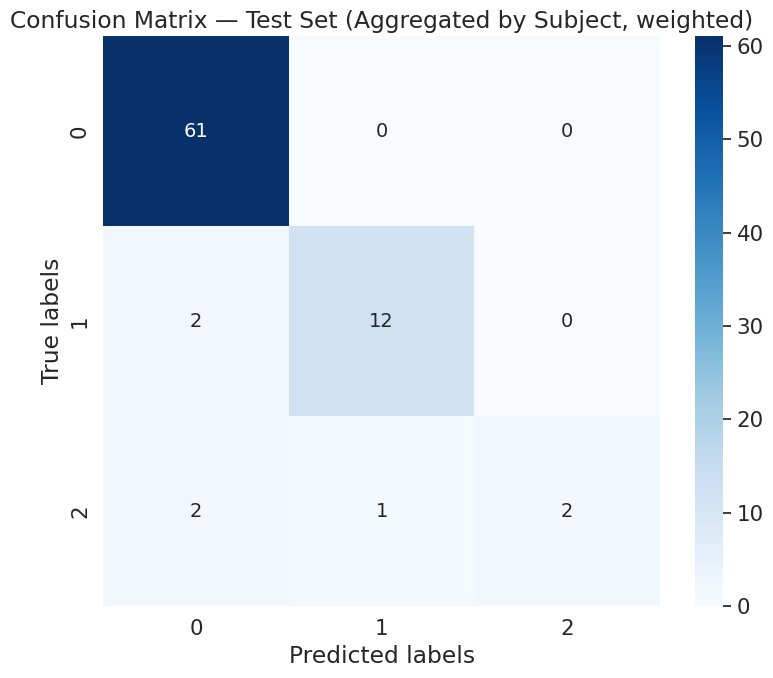

In [244]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set (Aggregated by Subject, weighted windows)

    rnn_model.eval()
    test_preds = []

    with torch.no_grad():
        # Batch-by-batch inference on X_test
        for i in range(0, len(X_test), 256):   # you can change the batch size
            xb = torch.tensor(X_test[i:i+256], dtype=torch.float32, device=device)
            logits = rnn_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    # Concatenate all batches
    test_preds = np.concatenate(test_preds, axis=0)       # shape: (N_windows, C)

    # --- Generate subj_ids and window starts for X_test ---
    subj_ids_test, window_starts_test = make_subj_ids(
        df_test, WINDOW_SIZE, STRIDE
    )

    assert len(subj_ids_test) == len(test_preds) == len(y_test), \
        "subj_ids_test, test_preds and y_test must have the same length!"

    # Compute weights for each test window
    test_window_weights = compute_window_weights(
        window_starts_test,
        window_size=WINDOW_SIZE,
        spans=IMPORTANT_SPANS,
        alphas=IMPORTANT_ALPHAS
    )

    # --- Aggregate predictions per subject (sample_index) ---
    unique_ids = np.unique(subj_ids_test)
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = (subj_ids_test == sid)

        probs_sid   = test_preds[mask]              # shape: (N_windows_subject, C)
        weights_sid = test_window_weights[mask]     # shape: (N_windows_subject,)

        # Same label for all windows of the same subject
        y_true_sid = y_test[mask][0]

        # ------- WEIGHTED AVERAGE OF PROBABILITIES -------
        w = weights_sid[:, None]                    # shape: (N_windows_subject, 1)
        probs_agg = (probs_sid * w).sum(axis=0) / w.sum()

        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds   = np.array(final_preds)
    final_targets = np.array(final_targets)

    # --- Global metrics on the test set ---
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set: {test_acc:.4f}")
    print(f"Precision over the test set: {test_prec:.4f}")
    print(f"Recall over the test set: {test_rec:.4f}")
    print(f"F1 score over the test set: {test_f1:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set (Aggregated by Subject, weighted)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipping Test Set Confusion Matrix as N_TEST_USERS is {N_TEST_USERS}")

In [241]:
# @title Generate Submission File for X_test_sub (weighted windows)

# Ensure the model is in evaluation mode
rnn_model.eval()

# ---- 1) Forward pass on all windows of X_test_sub ----

test_sub_window_preds = []

with torch.no_grad():
    for i in range(0, len(X_test_sub), 256):  # batch size 256 for inference
        xb = torch.tensor(X_test_sub[i:i+256], dtype=torch.float32, device=device)

        logits = rnn_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        test_sub_window_preds.append(probs)

test_sub_window_preds = np.concatenate(test_sub_window_preds, axis=0)  # shape: (N_windows, num_classes)

# ---- 2) Reconstruct subj_ids and window_starts for df_test_sub ----

subj_ids_sub, window_starts_sub = make_subj_ids(
    df_test_sub,
    window=WINDOW_SIZE,
    stride=STRIDE
)

print("subj_ids_sub:", subj_ids_sub.shape,
      "| window_starts_s:", window_starts_s.shape,
      "| preds:", test_sub_window_preds.shape)

assert len(subj_ids_sub) == len(test_sub_window_preds), \
    "subj_ids_sub and test_sub_window_preds must have the same length!"

# ---- 3) Compute window weights (larger if the window covers important spans) ----

window_weights_sub = compute_window_weights(
    window_starts_s,
    window_size=WINDOW_SIZE,
    spans=IMPORTANT_SPANS,
    alphas=IMPORTANT_ALPHAS
)

# ---- 4) Aggregation per subject with weighted average ----

unique_sample_indices = np.unique(subj_ids_sub)

final_predictions = []

for sid in unique_sample_indices:
    # Mask for all windows belonging to this subject
    mask = (subj_ids_sub == sid)

    probs_for_subject   = test_sub_window_preds[mask]     # shape: (W_sub, num_classes)
    weights_for_subject = window_weights_sub[mask]        # shape: (W_sub,)

    # Normalise weights so they sum to 1
    w = weights_for_subject[:, None]                    # shape: (W_sub, 1)
    weighted_probs = (probs_for_subject * w).sum(axis=0) / w.sum()

    predicted_label_index = int(np.argmax(weighted_probs))

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# ---- 5) Build the submission DataFrame ----

submission_df = pd.DataFrame(final_predictions)

inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

submission_file_path = os.path.join(
    current_dir.replace('\\', ''),
    'submission_gru_weighted.csv'
)

submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
print(submission_df.head())

subj_ids_sub: (11916,) | window_starts_s: (11916,) | preds: (11916, 3)
Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_gru_weighted.csv' created successfully.
   sample_index  predicted_label_index    label
0             0                      0  no_pain
1             1                      0  no_pain
2             2                      0  no_pain
3             3                      0  no_pain
4             4                      0  no_pain


## **K-Shuffle-Split Cross Validation**

In [245]:
# Cross-validation
K = 5
N_VAL_USERS = 100
N_TEST_USERS = 0

# Windowing
WINDOW_SIZE = 32
STRIDE = 16

# Training
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 30
VERBOSE = 10

# Architecture
HIDDEN_LAYERS = 2
HIDDEN_SIZE = 128
RNN_TYPE = 'GRU'
BIDIRECTIONAL = True

# Regularisation
DROPOUT_RATE = 0.2
L1_LAMBDA = 0
L2_LAMBDA = 0

In [246]:
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, n_test_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    K-fold shuffle split cross-validation per Pirate Pain (user-based split).

    df deve contenere almeno:
      - 'sample_index' (id soggetto)
      - colonne dei sensori (es. joint_*)
      - eventuali colonne di label usate da build_sequences
    """

    # Containers per i risultati
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    best_model_state = None
    best_f1_overall = -1
    best_norm = None
    best_test_users = None

    num_classes = 3  # no_pain, low_pain, high_pain

    joint_cols = [c for c in df.columns if c.startswith("joint_")]

    in_features = None
    initial_state = None

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # User-based split: Pirate usa 'sample_index'
        unique_users = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        n_train_users = len(unique_users) - n_val_users - n_test_users

        train_users = unique_users[:n_train_users]
        val_users   = unique_users[n_train_users:n_train_users + n_val_users]
        test_users  = unique_users[n_train_users + n_val_users:]

        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val   = df[df['sample_index'].isin(val_users)].copy()
        df_test  = df[df['sample_index'].isin(test_users)].copy()

        if verbose > 0:
            print(f"  Training set shape: {df_train.shape}")
            print(f"  Validation set shape: {df_val.shape}")
            print(f"  Test set shape: {df_test.shape}")

        # joint normalisation
        train_max = df_train[joint_cols].max()
        train_min = df_train[joint_cols].min()

        df_train[joint_cols] = (df_train[joint_cols] - train_min) / (train_max - train_min + 1e-8)
        df_val[joint_cols]   = (df_val[joint_cols]   - train_min) / (train_max - train_min + 1e-8)
        df_test[joint_cols]  = (df_test[joint_cols]  - train_min) / (train_max - train_min + 1e-8)

        # Sequenze Pirate (usa la tua build_sequences)
        X_train, y_train = build_sequences(df_train, window=window_size, stride=stride)
        X_val,   y_val   = build_sequences(df_val,   window=window_size, stride=stride)
        X_test,  y_test  = build_sequences(df_test,  window=window_size, stride=stride)

        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            print(f"  Test sequences shape: {X_test.shape}")


        if split_idx == 0:
            in_features = X_train.shape[2]

            model = RecurrentClassifier(
                input_size=in_features,
                hidden_size=hidden_size,
                num_layers=hidden_layers,
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type
            ).to(device)
            initial_state = copy.deepcopy(model.state_dict())
        else:

            model = RecurrentClassifier(
                input_size=in_features,
                hidden_size=hidden_size,
                num_layers=hidden_layers,
                num_classes=num_classes,
                dropout_rate=dropout_rate,
                bidirectional=bidirectional,
                rnn_type=rnn_type
            ).to(device)

            model.load_state_dict(initial_state)

        # Dataset & DataLoader
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
        val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
        test_ds  = TensorDataset(torch.from_numpy(X_test),  torch.from_numpy(y_test))

        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
        val_loader   = make_loader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
        test_loader  = make_loader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

        # Optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Mixed precision
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Checkpoint dir
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name + "/split_" + str(split_idx)
        )

        best_f1_split = max(training_history['val_f1'])

        fold_losses[f"split_{split_idx}"]  = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']
        best_scores[f"split_{split_idx}"]  = best_f1_split

        # If this is the best model so far → save it
        if best_f1_split > best_f1_overall:
            best_f1_overall = best_f1_split
            best_model_state = copy.deepcopy(model.state_dict())

            best_norm = (train_min.copy(), train_max.copy())

            best_test_users = test_users.copy()

    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores if k.startswith("split_")])
    best_scores["std"]  = np.std([best_scores[k] for k in best_scores if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    best_model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    best_model.load_state_dict(best_model_state)

    return fold_losses, fold_metrics, best_scores, best_model, best_norm, best_test_users

In [247]:
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores, best_model, best_norm, best_test_users = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    n_test_users=N_TEST_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

Split 1/5
  Training set shape: (89760, 42)
  Validation set shape: (16000, 42)
  Test set shape: (0, 42)
  Training sequences shape: (5049, 32, 36)
  Validation sequences shape: (900, 32, 36)
  Test sequences shape: (0,)
Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0576, F1 Score=0.5792 | Val: Loss=1.1979, F1 Score=0.2809
Epoch  10/500 | Train: Loss=0.4441, F1 Score=0.8618 | Val: Loss=0.6407, F1 Score=0.8443
Epoch  20/500 | Train: Loss=0.2760, F1 Score=0.9047 | Val: Loss=0.6353, F1 Score=0.8731
Epoch  30/500 | Train: Loss=0.1379, F1 Score=0.9355 | Val: Loss=0.6031, F1 Score=0.8922
Epoch  40/500 | Train: Loss=0.0423, F1 Score=0.9824 | Val: Loss=0.8881, F1 Score=0.8852
Epoch  50/500 | Train: Loss=0.0235, F1 Score=0.9874 | Val: Loss=0.8823, F1 Score=0.8984
Epoch  60/500 | Train: Loss=0.0110, F1 Score=0.9951 | Val: Loss=1.2075, F1 Score=0.9077
Epoch  70/500 | Train: Loss=0.0080, F1 Score=0.9961 | Val: Loss=1.3807, F1 Score=0.9135
Early stopping triggered after 79 epochs.
Best mode

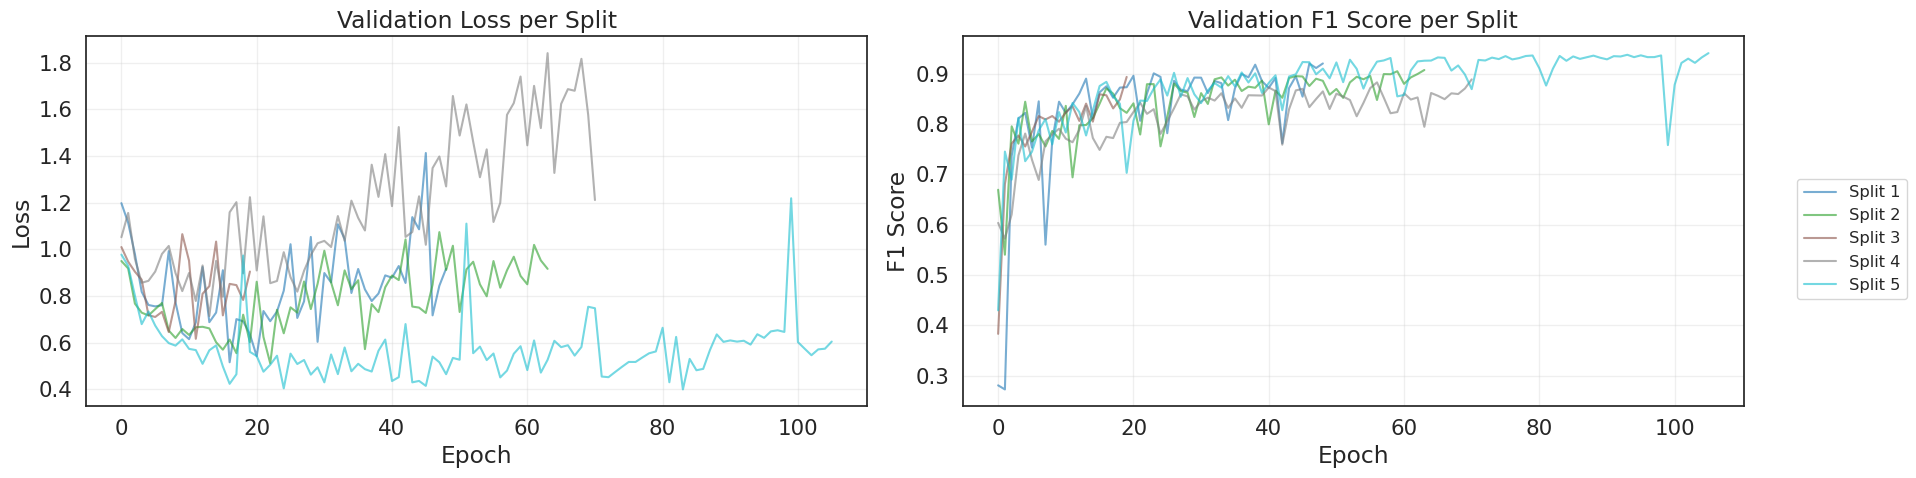

In [248]:
# @title Plot Hitory
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [249]:
if N_TEST_USERS > 0:
    # @title Plot Confusion Matrix — Test Set of BEST CV Split (Aggregated by Subject)

    best_model.eval()

    # -------------------------------------------
    # 1) Rebuild df_test of the BEST split
    # -------------------------------------------
    # best_test_users contains sample_index values of the test set of the best split
    df_test_best = df[df['sample_index'].isin(best_test_users)].copy()

    # -------------------------------------------
    # 2) Normalize using best split train min/max
    # -------------------------------------------
    best_train_min, best_train_max = best_norm

    joint_cols = [c for c in df_test_best.columns if c.startswith("joint_")]

    df_test_best[joint_cols] = (
        (df_test_best[joint_cols] - best_train_min[joint_cols]) /
        (best_train_max[joint_cols] - best_train_min[joint_cols] + 1e-8)
    )

    # -------------------------------------------
    # 3) Build sequences from NORMALIZED df_test_best
    # -------------------------------------------
    X_test_eval, y_test_eval = build_sequences(df_test_best, WINDOW_SIZE, STRIDE)

    test_preds = []

    with torch.no_grad():
        for i in range(0, len(X_test_eval), 256):
            xb = torch.tensor(X_test_eval[i:i+256], dtype=torch.float32, device=device)
            logits = best_model(xb)
            probs = torch.softmax(logits, dim=1)
            test_preds.append(probs.cpu().numpy())

    test_preds = np.concatenate(test_preds, axis=0)  # (N_windows, C)

    # -------------------------------------------
    # 4) Rebuild subject ids for df_test_best
    # -------------------------------------------
    subj_ids_test, _ = make_subj_ids(df_test_best, WINDOW_SIZE, STRIDE)

    assert len(subj_ids_test) == len(test_preds) == len(y_test_eval), \
        "subj_ids_test, test_preds and y_test_eval must have the same length!"

    # -------------------------------------------
    # 5) Aggregate window predictions per subject
    # -------------------------------------------
    unique_ids = np.unique(subj_ids_test)
    final_preds, final_targets = [], []

    for sid in unique_ids:
        mask = (subj_ids_test == sid)

        probs_sid = test_preds[mask]        # (W_subject, C)
        y_true_sid = y_test_eval[mask][0]   # label is constant per subject

        probs_agg = np.mean(probs_sid, axis=0)
        y_pred_sid = np.argmax(probs_agg)

        final_preds.append(y_pred_sid)
        final_targets.append(y_true_sid)

    final_preds = np.array(final_preds)
    final_targets = np.array(final_targets)

    # -------------------------------------------
    # 6) Metrics
    # -------------------------------------------
    test_acc  = accuracy_score(final_targets, final_preds)
    test_prec = precision_score(final_targets, final_preds, average='weighted')
    test_rec  = recall_score(final_targets, final_preds, average='weighted')
    test_f1   = f1_score(final_targets, final_preds, average='weighted')

    print(f"Accuracy over the test set (best split): {test_acc:.4f}")
    print(f"Precision over the test set (best split): {test_prec:.4f}")
    print(f"Recall over the test set (best split): {test_rec:.4f}")
    print(f"F1 score over the test set (best split): {test_f1:.4f}")

    # -------------------------------------------
    # 7) Confusion Matrix
    # -------------------------------------------
    cm = confusion_matrix(final_targets, final_preds)
    labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix — Test Set of Best CV Split (Aggregated by Subject)')
    plt.tight_layout()
    plt.show()

else:
    print(f"Skipping Test Set Confusion Matrix as N_TEST_USERS is {N_TEST_USERS}")

Skipping Test Set Confusion Matrix as N_TEST_USERS is 0


In [254]:
# @title Generate Submission File for X_test_sub — BEST FOLD NORMALIZATION

# Ensure the model is in evaluation mode
best_model.eval()

X_test_sub, y_test_sub = build_sequences(df_test_sub, WINDOW_SIZE, STRIDE)

# ----------------------------------------------------------
# 3) Window-level predictions
# ----------------------------------------------------------
test_sub_preds = []

with torch.no_grad():
    for i in range(0, len(X_test_sub), 256):  # batch inference
        xb = torch.tensor(X_test_sub[i:i+256], dtype=torch.float32, device=device)
        logits = best_model(xb)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        test_sub_preds.append(probs)

test_sub_preds = np.concatenate(test_sub_preds, axis=0)  # shape: (N_windows, num_classes)

# ----------------------------------------------------------
# 4) Rebuild subject ids using the NORMALIZED df_test_sub
# ----------------------------------------------------------
subj_ids_sub, _ = make_subj_ids(df_test_sub, WINDOW_SIZE, STRIDE)
unique_sample_indices = np.unique(subj_ids_sub)

assert len(test_sub_preds) == len(subj_ids_sub), \
    "Mismatch: test_sub_preds and subj_ids_sub must have same length."

# ----------------------------------------------------------
# 5) Aggregate window predictions per subject (mean aggregation)
# ----------------------------------------------------------
final_predictions = []

for sid in unique_sample_indices:
    mask = (subj_ids_sub == sid)
    probs_sid = test_sub_preds[mask]    # shape: (num_windows_subject, C)

    # Mean aggregation of window probabilities
    probs_agg = np.mean(probs_sid, axis=0)

    predicted_label_index = np.argmax(probs_agg)

    final_predictions.append({
        'sample_index': sid,
        'predicted_label_index': predicted_label_index
    })

# ----------------------------------------------------------
# 6) Build submission DataFrame and save CSV
# ----------------------------------------------------------
submission_df = pd.DataFrame(final_predictions)

inverse_label_mapping = {v: k for k, v in label_mapping.items()}
submission_df['label'] = submission_df['predicted_label_index'].map(inverse_label_mapping)

submission_file_path = os.path.join(
    current_dir.replace('\\', ''),
    'submission_grubi_kfold.csv'
)

submission_df[['sample_index', 'label']].to_csv(submission_file_path, index=False)

print(f"Submission file '{submission_file_path}' created successfully.")
submission_df.head()

Submission file '/gdrive/My Drive/[2025-2026] AN2DL/Challenge 1/submission_grubi_kfold.csv' created successfully.


,sample_index,predicted_label_index,label
0,0,0,no_pain
1,1,0,no_pain
2,2,0,no_pain
3,3,0,no_pain
4,4,0,no_pain
